# setup

In [2]:
import datetime
import json
import os
import time
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import praw
import urllib3.exceptions
from dotenv import load_dotenv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from praw.models import MoreComments
from prawcore.exceptions import RequestException, ResponseException, ServerError
from tqdm import tqdm
from wordcloud import WordCloud

In [3]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Change parameters here

In [4]:
# CHANGE HERE: maximum subreddit/posts/comments to retrieve
# max: 100 based on the documentation
LIMIT_SUBREDDITS_PER_KEYWORD = 100 # max subreddits per keyword
LIMIT_POSTS = 10
LIMIT_COMMENTS = 10
POSTS_TIME_FILTER = "year" # all/day/hour/month/week/year

# Feel free to modify these files to suit your needs
KEYWORD_FILE = '../ai_keywords.txt'

# Progress files
SUBREDDITS_PROGRESS_FILE = 'progress_subreddits.json'
POSTS_PROGRESS_FILE = 'posts_progress.json'
COMMENTS_PROGRESS_FILE = 'comments_progress.json'

# Output files
SUBREDDITS_FILE = 'subreddits.json'
POSTS_FILE = 'posts.json'
COMMENTS_FILE = 'comments.json'

# Date of ChatGPT release
CHATGPT_RELEASE_DATE = datetime.datetime(2022, 11, 30).timestamp()

INITIAL_WAIT_TIME = 240
MAX_RETRIES = 5

# Setup reddit credentials

In [5]:
from pprint import pprint

load_dotenv()
reddit_info = {
    "username": os.getenv("REDDIT_USERNAME"),
    "password": os.getenv("REDDIT_PASSWORD"),
    "personal_use_script": os.getenv("REDDIT_PERSONAL_USE_SCRIPT"),
    "secret": os.getenv("REDDIT_SECRET"),
    "user_agent": os.getenv("REDDIT_USER_AGENT"),
}
pprint(reddit_info)

{'password': 'm2229@t05',
 'personal_use_script': '0Fvnl3H9BuS0YgA20mqw4Q',
 'secret': 'qIhF7rM2xZCu1qHf2cbIBrxenajPGQ',
 'user_agent': 'muehuhu:user',
 'username': 'muehuhu'}


In [6]:
# https://praw.readthedocs.io/en/stable/getting_started/quick_start.html

reddit = praw.Reddit(
    username=reddit_info["username"],
    password=reddit_info["password"],
    client_id=reddit_info["personal_use_script"],
    client_secret=reddit_info["secret"],
    user_agent=reddit_info["user_agent"],
)

print(reddit.read_only)
# Output: False

False


# searching for subreddits

### for exception handling

In [7]:
# Function to handle retries with exponential backoff
def retry_on_failure(func, max_retries=5, initial_delay=1, backoff_factor=2, *args, **kwargs):
    retries = 0
    delay = initial_delay
    while retries < max_retries:
        try:
            return func(*args, **kwargs)
        except (RequestException, ResponseException, ServerError, urllib3.exceptions.NewConnectionError) as e:
            print(f"Error occurred: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
            delay *= backoff_factor
            retries += 1
    raise Exception(f"Max retries exceeded for function: {func.__name__}")

### methods

#### get subreddit

In [16]:
# Function to get subreddits
def get_subreddits(keywords, limit_subreddits=5, progress_file=SUBREDDITS_PROGRESS_FILE):
    subreddits_by_keyword = {}
    subreddits = []

    # Load progress from file if it exists
    try:
        with open(progress_file, 'r') as f:
            progress = json.load(f)
    except FileNotFoundError:
        progress = {}

    try:
        for keyword in tqdm(keywords, desc="retrieving subreddit names"):
            if keyword not in progress:
                progress[keyword] = {'processed': False}

            if progress[keyword]['processed']:
                continue

            results = reddit.subreddits.search(keyword, limit=limit_subreddits)
            subreddits_by_keyword[keyword] = []
            for result in results:
                if result.display_name not in subreddits:
                    subreddits.append(result.display_name)
                subreddits_by_keyword[keyword].append(result.display_name)

            progress[keyword]['processed'] = True

            # Save progress in the loop
            with open(progress_file, 'w') as f:
                json.dump(progress, f)

    except Exception as e:
        print(f"An error occurred: {e}")

        # Save progress if an error occurs
        with open(progress_file, 'w') as f:
            json.dump(progress, f)

    return subreddits_by_keyword


#### get top posts and comments v3

In [7]:
def load_existing_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

def save_data(file_path, data):
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4)

def get_top_posts_and_comments(subreddits, limit_posts=10, limit_comments=10, initial_wait_time=INITIAL_WAIT_TIME, max_retries=MAX_RETRIES):
    posts_data = load_existing_data(POSTS_FILE)
    comments_data = load_existing_data(COMMENTS_FILE)

    # Load posts progress from file if it exists
    try:
        with open(POSTS_PROGRESS_FILE, 'r') as f:
            posts_progress = json.load(f)
    except FileNotFoundError:
        posts_progress = {}

    try:
        for subreddit in tqdm(subreddits, desc="Fetching posts and comments"):
            if subreddit in posts_progress and posts_progress[subreddit]['processed']:
                continue

            subreddit_posts = []
            subreddit_comments = []

            # Fetch top posts with retry logic
            for attempt in range(max_retries):
                try:
                    for submission in reddit.subreddit(subreddit).top('year', limit=limit_posts):
                        post_info = {
                            'id': submission.id,
                            'title': submission.title,
                            'score': submission.score,
                            'url': submission.url,
                            'num_comments': submission.num_comments
                        }
                        subreddit_posts.append(post_info)

                        # Fetch top comments
                        submission.comments.replace_more(limit=0)
                        post_comments = []
                        for comment in submission.comments.list()[:limit_comments]:
                            if isinstance(comment, praw.models.MoreComments):
                                continue
                            comment_info = {
                                'id': comment.id,
                                'body': comment.body,
                                'score': comment.score
                            }
                            post_comments.append(comment_info)

                        subreddit_comments.append({submission.id: post_comments})

                    break  # Break if successful
                except Exception as e:
                    print(f"An error occurred: {e}")
                    if attempt < max_retries - 1:
                        wait_time = initial_wait_time * (2 ** attempt)
                        print(f"Retrying in {wait_time} seconds...")
                        time.sleep(wait_time)
                    else:
                        print("Max retries exceeded, saving progress and exiting...")
                        raise

            # Append new data to the existing data
            if subreddit not in posts_data:
                posts_data[subreddit] = []
            posts_data[subreddit].extend(subreddit_posts)

            if subreddit not in comments_data:
                comments_data[subreddit] = []
            comments_data[subreddit].extend(subreddit_comments)

            posts_progress[subreddit] = {'processed': True}

            # Save progress and data in the loop
            save_data(POSTS_PROGRESS_FILE, posts_progress)
            save_data(POSTS_FILE, posts_data)
            save_data(COMMENTS_FILE, comments_data)

    except Exception as e:
        print(f"An error occurred: {e}")

        # Save progress and data if an error occurs
        save_data(POSTS_PROGRESS_FILE, posts_progress)
        save_data(POSTS_FILE, posts_data)
        save_data(COMMENTS_FILE, comments_data)

    return posts_data, comments_data

### running - retrieve keywords from file

In [12]:
# retrieves relevant keywords from file
keywords = []
with open(KEYWORD_FILE, 'r', encoding='utf-8') as keywordstxt:
    keywords = [line.rstrip('\n') for line in keywordstxt]
pprint(keywords)


['Open Source',
 'License',
 'GitHub',
 'Artificial Intelligence',
 'LLama',
 'AI',
 'Machine Learning',
 'ML',
 'Large Language Models',
 'LLM',
 'Chatbot',
 'OpenAI',
 'ChatGPT',
 'DALL-E',
 'GPT',
 'Prompt',
 'Generative AI']


### running - get relevant subreddits

#### calling api and storing subreddit lists in a file - NOTE: don't forget to remove progress files after finishing

In [17]:
# Get subreddits and their counts
reoloaded_subreddits_by_keyword = get_subreddits(keywords, limit_subreddits=LIMIT_SUBREDDITS_PER_KEYWORD)
print("Subreddit counts by keyword before saving to file:")
pprint(reoloaded_subreddits_by_keyword)

# Output the dictionary to a JSON file
with open(SUBREDDITS_FILE, 'w', encoding='utf-8') as f:
    json.dump(reoloaded_subreddits_by_keyword, f, indent=4)

print("Subreddits by keyword saved to JSON file.")

retrieving subreddit names: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

Subreddit counts by keyword before saving to file:
{'AI': ['HentaiAI',
        'AiUncensored',
        'CharacterAI',
        'singularity',
        'AI_Girl',
        'CharacterAi_NSFW',
        'artificial',
        'ChatGPT',
        'AiPornhubvideo',
        'Futanari_Ai',
        'ArtificialInteligence',
        'OpenAI',
        'MyAiGF',
        'BDSM_AI',
        'StableDiffusion',
        'Futurology',
        'FutaAI',
        'Naked_AI_',
        'eu4',
        'technology',
        'TransformationAI',
        'pornWorksAI',
        'civ',
        'AIDungeon',
        'pregnant_AI',
        'Shemale_AI',
        'Stellaris',
        'hoi4',
        'MonsterGirlAI',
        'AI_CartoonPorn',
        'france',
        'totalwar',
        'SeducedAI',
        '18plus_AiArt',
        'WritingPrompts',
        'CrusaderKings',
        'aiArt',
        'AvatarAI',
        'Romania',
        'Showerthoughts',
        'AI_NSFW_porn',
        'HypnoAI',
        'MachineLearning',
   

#### reloading

In [8]:
# Reload subreddit names from the JSON file after optional inspections/edits
with open(SUBREDDITS_FILE, 'r', encoding='utf-8') as f:
    reloaded_subreddits_by_keyword = json.load(f)

print("Subreddit counts by keyword after reloading from file:")
pprint(reloaded_subreddits_by_keyword)


Subreddit counts by keyword after reloading from file:
{'AI': ['artificial',
        'ChatGPT',
        'singularity',
        'technology',
        'ArtificialInteligence',
        'Futurology',
        'MachineLearning',
        'OpenAI',
        'replika',
        'StableDiffusion',
        'ProgrammerHumor',
        'ClaudeAI',
        'PygmalionAI',
        'SillyTavernAI',
        'perplexity_ai'],
 'Artificial Intelligence': ['artificial',
                             'ArtificialInteligence',
                             'Futurology',
                             'singularity',
                             'technology',
                             'MachineLearning',
                             'agi',
                             'AIethics',
                             'automation',
                             'OpenAI',
                             'programming',
                             'intelligenceagents',
                             'compsci',
                       

### running - get top posts and comments

In [9]:
# Assuming subreddits_by_keyword is already loaded or fetched
subreddits = list(reloaded_subreddits_by_keyword.values())

# Flatten the list of subreddits
flattened_subreddits = [item for sublist in subreddits for item in sublist]

# Get posts and comments with retry mechanism
posts_data, comments_data = get_top_posts_and_comments(flattened_subreddits, limit_posts=10, limit_comments=10, initial_wait_time=INITIAL_WAIT_TIME, max_retries=MAX_RETRIES)

print("Posts and comments data saved to JSON files.")


Fetching posts and comments:   0%|          | 0/318 [00:00<?, ?it/s]C:\Users\prach\AppData\Local\Temp\ipykernel_2732\1990818740.py:34: DeprecationWarning: Positional arguments for 'BaseListingMixin.top' will no longer be supported in PRAW 8.
Call this function with 'time_filter' as a keyword argument.
  for submission in reddit.subreddit(subreddit).top('year', limit=limit_posts):


An error occurred: received 403 HTTP response
Retrying in 240 seconds...


### running - get top posts and comments

In [33]:
data = {}
post_count = 0
progress_file = 'progress_subreddits.json'
progress = {}

# Load progress from file if it exists
if os.path.exists(progress_file):
    with open(progress_file, 'r') as f:
        progress = json.load(f)

for subreddit in tqdm(subreddits, desc="Processing subreddits"):
    if subreddit in progress and progress[subreddit].get('processed', False):
        continue

    posts = get_top_posts(subreddit, limit_posts=LIMIT_POSTS, after=CHATGPT_RELEASE_DATE)
    post_count += len(posts)
    data[subreddit] = []
    for post in tqdm(posts, desc=f"Processing posts in {subreddit}"):
        post_data = {
            "title": post.title,
            "description": post.selftext,
            "comments": get_comments(post, limit_comments=LIMIT_COMMENTS)
        }
        data[subreddit].append(post_data)

    progress[subreddit] = {'processed': True}

    # Save progress to file
    with open(progress_file, 'w') as f:
        json.dump(progress, f)

# Save results to JSON with proper formatting
with open("reddit_analysis.json", "w", encoding='utf-8') as outfile:
    json.dump(data, outfile, ensure_ascii=False, indent=4)

# Analysis Summary
print(f"Number of subreddits analyzed: {len(subreddits)}")
print(f"Number of posts analyzed: {post_count}")


Processing subreddits: 100%|██████████| 2/2 [00:04<00:00,  2.08s/it]

Number of subreddits analyzed: 2
Number of posts analyzed: 3


# data analysis

In [34]:
# Function to generate co-occurrence matrix
def co_occurrence_matrix(texts):
    words = []
    for text in texts:
        words.extend(word_tokenize(text))
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    co_occurrences = Counter()
    for i in range(len(words)):
        for j in range(i + 1, len(words)):
            if words[i] != words[j]:
                co_occurrences[frozenset([words[i], words[j]])] += 1
    return co_occurrences

In [35]:
# Generate co-occurrence matrices for each subreddit
co_occurrences = {}
all_texts = []
for subreddit, posts in data.items():
    for post in posts:
        texts = [post["title"], post["description"]] + post["comments"]
        all_texts.extend(texts)
        matrix = co_occurrence_matrix(texts)
        if subreddit not in co_occurrences:
            co_occurrences[subreddit] = Counter()
        co_occurrences[subreddit] += matrix

In [36]:
# Word frequency analysis
all_words = [word.lower() for text in all_texts for word in word_tokenize(text) if word.isalpha() and word.lower() not in stop_words]
word_freq = Counter(all_words)

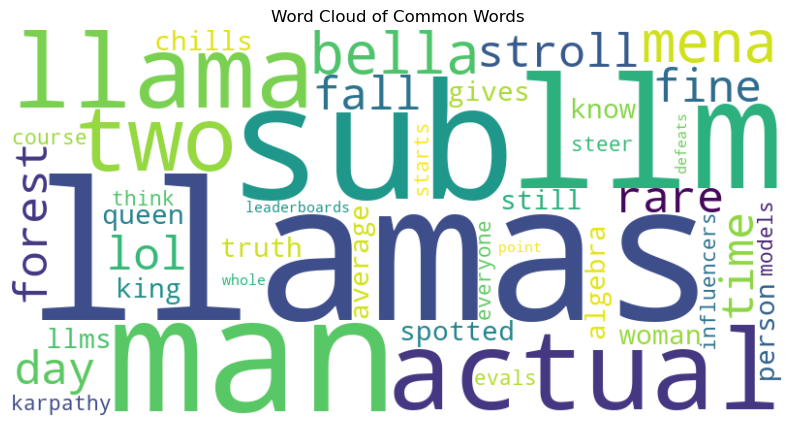

In [37]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Words')
plt.show()

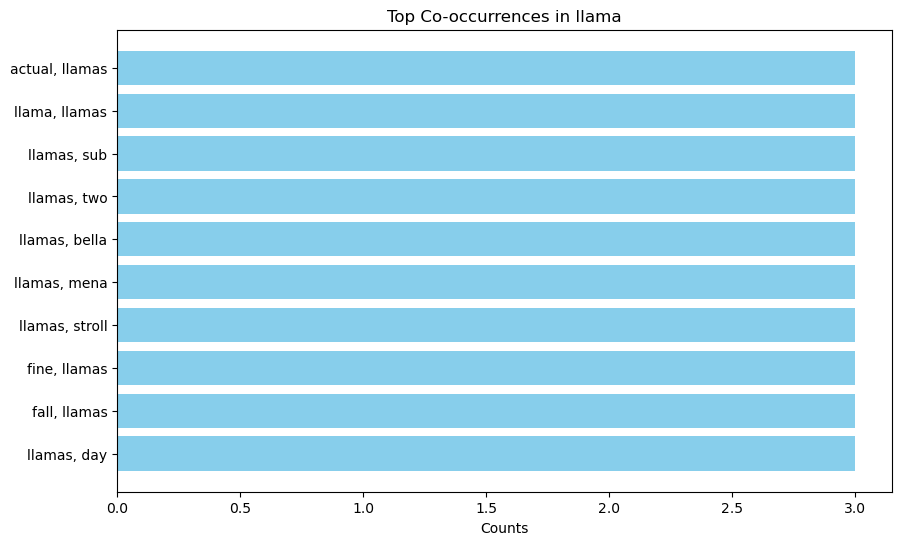

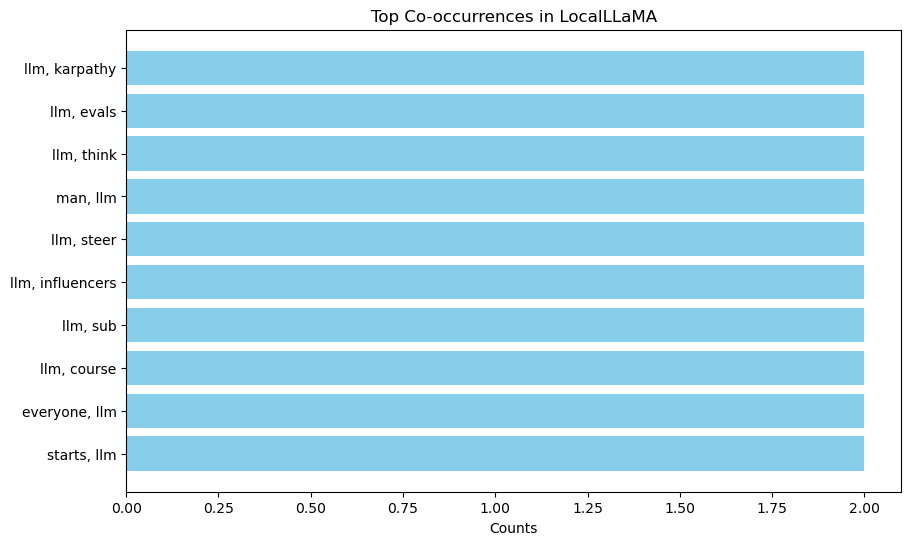

In [38]:
# Plot co-occurrence matrices
for subreddit, matrix in co_occurrences.items():
    sorted_matrix = dict(sorted(matrix.items(), key=lambda item: item[1], reverse=True)[:10])
    words = [', '.join(list(pair)) for pair in sorted_matrix.keys()]
    counts = list(sorted_matrix.values())

    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Counts')
    plt.title(f'Top Co-occurrences in {subreddit}')
    plt.gca().invert_yaxis()
    plt.show()

In [39]:
# Summary table of top 10 words and their frequencies
summary_df = pd.DataFrame(word_freq.most_common(10), columns=["Word", "Frequency"])
print(summary_df)

     Word  Frequency
0  llamas          3
1     sub          2
2     man          2
3     llm          2
4  actual          1
5   llama          1
6     two          1
7   bella          1
8    mena          1
9  stroll          1
